# How can we predict and mitigate customer churn using machine learning techniques?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import  LabelEncoder
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
original = pd.read_csv("../../data/processed/Compaign_metrics.csv")

## Develop a machine learning model to predict the likelihood of customer churn.

In [3]:
original['Churn'] = original['Attrition_Flag'].apply(lambda x: 'No' if x == 'Existing Customer' else 'Yes')
ori = original.copy()
ori = original.drop(columns = ['Attrition_Flag'])

In [4]:
total_customers = ori['Churn'].count()
churners = ori[ori['Churn'] == 'Yes'].shape[0]
churn_rate = churners / total_customers * 100
print(f"The Churn Rate is quite high at {churn_rate:.2f}%.")

The Churn Rate is quite high at 15.72%.


### Likelihood of Churning for each customer

#### Preparing the data

In [8]:
np.random.seed(3101)

# encoding 'Income_Category', 'Product_Usage', 'Cluster_Labels' and 'Churn' to numerical formats
encoders = {}
for c in ['Gender', 'Income_Category', 'Education_Level', 'Marital_Status', 'Card_Category'
          , 'Churn']:
    le = LabelEncoder()
    ori[c] = le.fit_transform(ori[c])
    encoders[c] = le

# splitting the data into training and test
## training data size: 80%; test data size: 20%
X = ori.drop(columns = ['Churn'])
y = ori['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

#### Random Forest Classifier

To add Churn_Probability to the data.

In [9]:
model = RandomForestClassifier(random_state = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
churn_probabilities = model.predict_proba(X)[:, 1]

# add likelihood of a customer churning into the dataset
original['Churn_Probability'] = churn_probabilities

#### Testing viability

##### Accuracy and F1 scores

In [10]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 score: {f1:.4f}")

Accuracy: 0.9313
F1 score: 0.7509


The accuracy is quite high at 93.13%. This shows that the model accurately classifies the customer into churned or not churned 94.27% of the time. However, this should not be trusted because most people did not churn (83.93%) in the data.

The F1 score is relatively high 75.09%. It is average of precision and recall and both of these contribute equally to the F1 score (Sharma, 2023). The model as a modest ability in predicting true positives (customers who actually churn). 

##### AUC - ROC 

AUC-ROC score: 0.9692


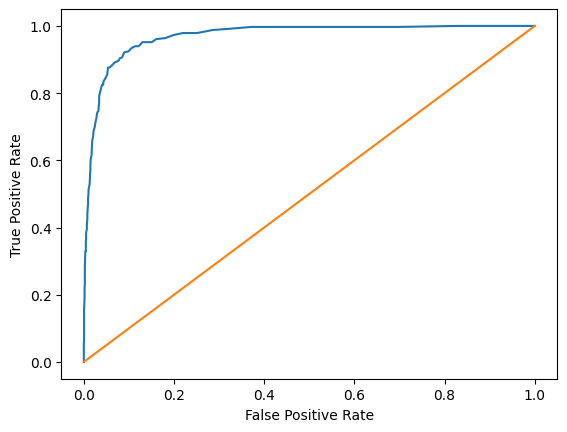

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Month_with_bank,No_of_product,...,Savings,Duration_of_Contact,Num_of_Contacts_Made,Last_Contacted,Outcome,Loyalty,Financial_Status,Segment,Digital_Capability,Churn
0,768805383,45,1,3,3,1,2,0,39,5,...,452014.73,73,2,-1,0,4,7,2,True,0
1,818770008,49,0,5,2,2,4,0,44,6,...,0.00,70,1,-1,0,3,3,1,True,0
2,713982108,51,1,3,2,1,3,0,36,4,...,300598.61,206,3,-1,0,3,5,2,True,0
3,709106358,40,1,3,5,1,2,0,21,5,...,0.00,977,1,-1,0,3,5,2,True,0
4,713061558,44,1,2,2,1,1,0,36,3,...,184422.42,15,1,9,0,2,4,2,True,0


In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC score: {auc:.4f}")

# plotting the AUC-ROC
false_pos_r, true_pos_r, thresholds = roc_curve(y_test, y_prob)
plt.plot(false_pos_r, true_pos_r)
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The AUC-ROC score is high at 96.92%. The model has significant in predicting the likelihood of a customer churning. The model correctly classifies with a probability of 96.92%.

### Early Warning System

In [23]:
# Calculate mean and median Transaction_Behavior for churned vs. non-churned customers
churned = ori[ori['Churn'] == 1]
non_churned = ori[ori['Churn'] == 0]

churned_mean = churned['Financial_Status'].mean()
non_churned_mean = non_churned['Financial_Status'].mean() 

print("Average Financial_Status for churned customers:", churned_mean)
print("Average Financial_Status for non-churned customers:", non_churned_mean)
# Since churned customers have a lower Financial_Status value on average, it suggests that lower Financial_Status values correlate with a higher churn risk.

# Calculate the 25th percentile of the 'Loyalty' column for both groups
churned_loyalty_25th = churned['Loyalty'].quantile(0.25)
non_churned_loyalty_25th = non_churned['Loyalty'].quantile(0.25)

churned_loyalty_25th, non_churned_loyalty_25th # to find which treshold to set for loyalty

# Defining threshold criteria for high-risk customers
churn_status_threshold = 1         # Let 1 = churned, 0 = non-churned
financial_status_threshold = 4.0     # Threshold for financial status
loyalty_threshold = 3              # Threshold for loyalty

# Apply early warning system criteria
ori['Alert'] = ori.apply(
    lambda row: 'High risk of churn - follow up needed' if (
        row['Churn'] >= churn_status_threshold or              # Churned or likely to churn
        row['Financial_Status'] < financial_status_threshold or # Low financial stability
        row['Loyalty'] < loyalty_threshold                     # Low loyalty score
    ) else 'Low risk',
    axis=1
)

# Display results
print(ori[['CLIENTNUM', 'Churn', 'Financial_Status', 'Loyalty', 'Alert']])

# Count high-risk and low-risk customers
risk_counts = ori['Alert'].value_counts()
print("\nCustomer Risk Summary:")
print(risk_counts)  # high risk = 2670, low risk = 4411

Average Financial_Status for churned customers: 5.098831985624439
Average Financial_Status for non-churned customers: 5.262734584450402
      CLIENTNUM  Churn  Financial_Status  Loyalty  \
0     768805383      0                 7        4   
1     818770008      0                 3        3   
2     713982108      0                 5        3   
3     709106358      0                 5        3   
4     713061558      0                 4        2   
...         ...    ...               ...      ...   
7076  710841183      0                 5        9   
7077  713899383      0                 5        8   
7078  772366833      0                 4        8   
7079  716506083      1                 3        7   
7080  714337233      1                 4        7   

                                      Alert  
0                                  Low risk  
1     High risk of churn - follow up needed  
2                                  Low risk  
3                                  Low risk

#### Retention Strategies

1. Personalized Communication Targeted Messaging: Use customer data to send tailored emails that acknowledge individual preferences and behaviors. Highlight relevant promotions or services to create a more personalized experience, which can significantly enhance engagement and satisfaction.

2.  Incentives and Rewards Loyalty Programs: Implement a rewards program that encourages continued use of your services. Offering points, discounts, or exclusive benefits can motivate high-risk customers to remain loyal and feel valued.

3. Enhanced Customer Support Dedicated Account Management: Assign dedicated account managers to high-risk customers. This personalized support ensures their concerns are addressed promptly and reinforces the commitment to customer satisfaction, fostering a stronger relationship and trust.

In [59]:
# for API
A_BQ3 = original[["CLIENTNUM", "Churn_Probability"]]
A_BQ3.to_csv('../data/processed/temp4.csv', index = False)